In [1]:

import time

import random

import matplotlib.pyplot as plt


In [2]:

def hadamard_ratio(basis):
    """
    Returns the Hadamard ratio of a basis of vectors

    Parameters:
        basis - a list of vectors that span a lattice
    """

    n = basis.nrows()
    product_of_norms = prod([vec.norm() for vec in basis])
    if product_of_norms == 0:
        return 0

    exact = (abs(basis.det()) / product_of_norms) ^ (1 / n)
    return exact.n()


In [3]:

def random_unimodular_matrix(ring, nrows, scale=None, rand=None):
    """
    Returns a random n by n unimodular matrix. The matrix should be composed of
    elements on the order 'scale'. The matrix is calculared by multiplying
    together random upper and lower triangular matrices.

    Parameters:
        n     - the size of the matrix
        scale - (defualt: 1000) the scale of entries in the matrix
        rand  - (default: (-1, 1)) the range of triangular matrix entries
    """

    if scale is None:
        scale = 1000

    if rand is None:
        rand = (-1, 1)

    m = identity_matrix(nrows)
    r = identity_matrix(nrows)

    while max(x for vec in m for x in vec) <= scale:
        # Randomly permute the columns of m
        for i in range(nrows):
            m.swap_rows(i, random.randrange(i, nrows))

        # Randomize the upper triangle of matrix r
        for i in range(nrows):
            for j in range(i + 1, nrows):
                r[i, j] = random.randint(*rand)

        # Randomly alternate between upper and lower triangular matrices
        if random.choice([False, True]):
            m *= r
        else:
            m *= r.transpose()

    return m



random_unimodular_matrix(ZZ, 3, 100)


[ 197   15 -117]
[  77    7  -46]
[  10    1   -6]

In [7]:

def round_matrix(mat):
    new_mat = matrix(ZZ, mat.nrows(), mat.ncols())
    for x in range(mat.nrows()):
        for y in range(mat.ncols()):
            new_mat[x,y] = mat[x,y].round()
    return new_mat

def matrix_max(mat):
    return max(x for vec in mat for x in vec)


In [56]:

def random_hadamard_bounded_matrix(n, scale=None, min_bound=0.0, max_bound=1.0):
    if scale is None:
        scale = 100
    
    target = min_bound + (max_bound - min_bound) * random.random()

    m_low = random_matrix(ZZ, n, n, x=-scale, y=scale)
    m_low = m_low * random_unimodular_matrix(ZZ, n, scale ^ 3)
    m_low = round_matrix(m_low * scale / matrix_max(m_low))

    m_high = random_matrix(ZZ, n, n, x=-scale, y=scale)
    m_high = round_matrix(m_high.gram_schmidt()[0])

    return round_matrix(target * m_high + (1 - target) * m_low)

mat = random_hadamard_bounded_matrix(8, 100, min_bound=0.5, max_bound=0.5)

print(hadamard_ratio(mat))
print(mat)


0.802086648488557
[-34 -58  29   4  42 -17   9 -39]
[-30  22  43 -25 -14 -23   2  39]
[-63 -53  -4  -9  15  43   7  -2]
[ -8  42 -18 -49  17  -3 -44 -29]
[ 27 -41   5 -41  46  16  19  24]
[-16 -35 -17  -3  11 -17   4   2]
[ 18  55  13  16   9  -4  -7   8]
[  0  39  -6   4   0   8  22   3]


In [55]:

def gen_good_basis(n, scale=None, ratio=None):
    """
    Generate a "good" basis for a random lattice with a large Hadamard ratio.

    Parameters:
        n - the number of dimensions of the good basis
        scale - range of random values of the good basis
        ratio - (default: 0.95) the minimum hadamard ratio of the good basis
    """

    if ratio is None:
        ratio = 0.95
    
    if scale is None:
        scale = 100
    
    basis = random_matrix(ZZ, n, n, x=-scale, y=scale)
    while hadamard_ratio(basis) < ratio:
        basis = random_matrix(ZZ, n, n, x=-scale, y=scale)

    return round_matrix(basis)


In [32]:

def gen_bad_basis(basis, ratio=None, scale=None):
    """
    Generate a "bad" basis with a small Hdamard ratio and large entries that
    spans the same lattice as a "good" input lattice.

    Parameters:
        basis - the original basis for a lattice
        ratio - (default: 0.1) the maximum hadamard ratio of the bad basis
        scale - (default: 100) the approximate scale factor of the bad basis
    """

    if ratio is None:
        ratio = 0.1

    if scale is None:
        scale = 100

    n = basis.nrows()

    new_basis = random_unimodular_matrix(ZZ, n, scale=scale) * basis
    while hadamard_ratio(new_basis) > ratio:
        new_basis = random_unimodular_matrix(ZZ, n, scale=scale) * basis

    return new_basis


In [34]:

def ggh_encrypt(public_basis, message, delta=None, rand=None):
    """
    Returns an encrypted message using the GGH encryption algorithm.

    Parameters:
        public_basis - the public key used in GGH (a bad basis for a lattice)
        message - a vector containing the unencrypted message
        delta - (default: 10) the range of values for the random vector perturbation
        rand - (randomized by default) the random vector perturbation
    """

    if delta is None:
        delta = 10

    if rand is None:
        rand = random_matrix(ZZ, 1, public_basis.nrows(), x=-delta, y=delta)

    return  message * public_basis + rand


In [35]:

def ggh_decrypt(private_basis, public_basis, encrypted_message):
    """
    Returns a decrypted message using the GGH encryption algorithm.

    Parameters:
        private_basis - the private key used in GGH (a good basis for a lattice)
        public_basis  - the public key used in GGH (a bad basis for a lattice)
        message - a vector containing the encrypted message
    """

    # Find the lattice vector v closest to the vector of the encrypted message
    v = round_matrix(encrypted_message * private_basis.inverse()) * private_basis

    # Express v as a linear combination of public basis, revealing the original message
    return round_matrix(v * public_basis.inverse())


In [36]:

def ggh_crack(public_basis, encrypted_message):
    # Find a good basis for the lattice
    good_basis = public_basis.LLL()

    # Decrypt using the good basis as if it's the private basis
    return ggh_decrypt(good_basis, public_basis, encrypted_message)


# Tests

# Experiments

In [37]:

def bin_by_ratios(points, nbins):
    bins = [(0, 0) for i in range(nbins)]
    xmin = min(x[0] for x in points)
    xmax = max(x[0] for x in points)
    delta = (xmax - xmin) / nbins

    for x in points:
        index = min(int((x[0] - xmin) / delta), nbins - 1)
        bins[index] = (bins[index][0] + x[1], bins[index][1] + 1)

    ratios    = [xmin + (i + 0.5) * delta for i in range(nbins) if bins[i][1] != 0]
    successes = [v[0] / v[1] for v in bins if v[1] != 0]

    return ratios, successes


<Figure size 432x288 with 0 Axes>

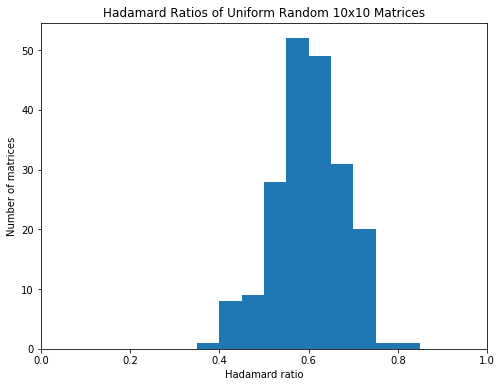

<Figure size 432x288 with 0 Axes>

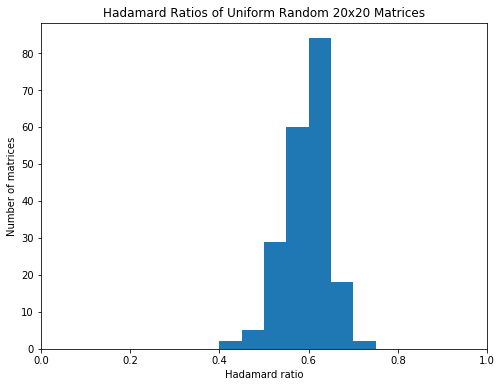

<Figure size 432x288 with 0 Axes>

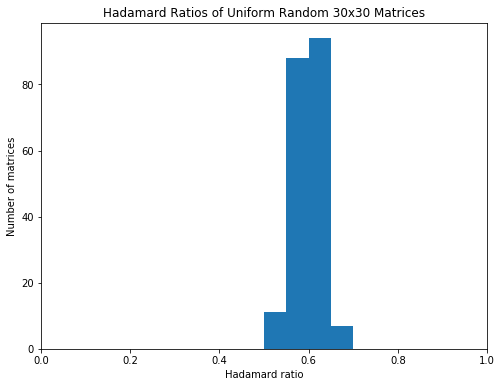

<Figure size 432x288 with 0 Axes>

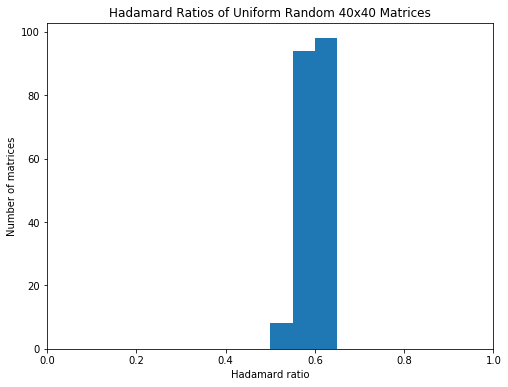

<Figure size 432x288 with 0 Axes>

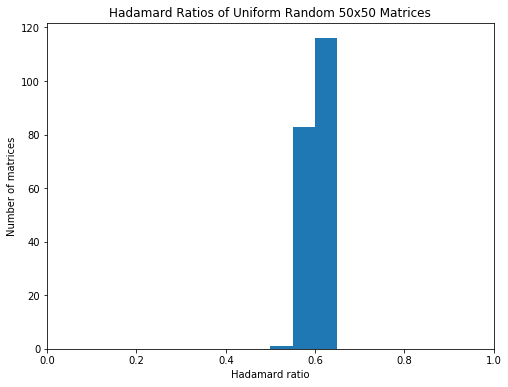

<Figure size 432x288 with 0 Axes>

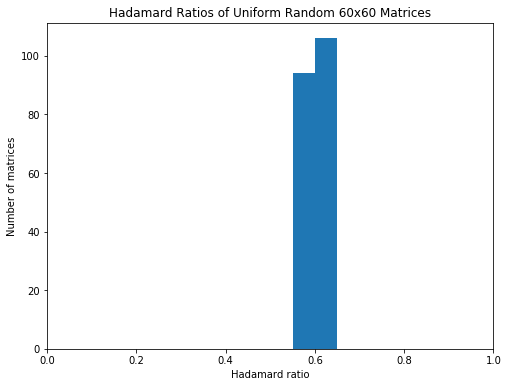

In [52]:
for n in [10, 20, 30, 40, 50, 60]:
    bound = 1000
    trials = 200
    nbins = 20
    
    bins = [i / nbins for i in range(nbins + 1)]
    
    rand_mat = lambda: random_matrix(ZZ, n, n, x=-bound, y=bound, density=1.0, distribution='uniform')
    ratios = [hadamard_ratio(rand_mat()) for i in range(trials)]
    
    plt.clf()
    fig = plt.figure(figsize=(8, 6))
    plt.title('Hadamard Ratios of Uniform Random {0}x{0} Matrices'.format(n))
    plt.xlabel('Hadamard ratio')
    plt.ylabel('Number of matrices')
    plt.xlim(0.0, 1.0)
    plt.hist(ratios, bins=bins)
    fig.savefig('./img/hadamard_ratios_{}.png'.format(n), dpi=100)
    plt.show()


<Figure size 432x288 with 0 Axes>

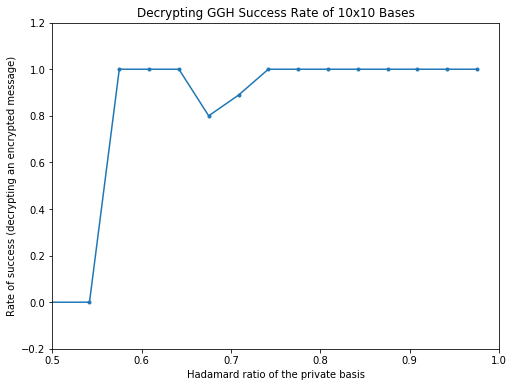

<Figure size 432x288 with 0 Axes>

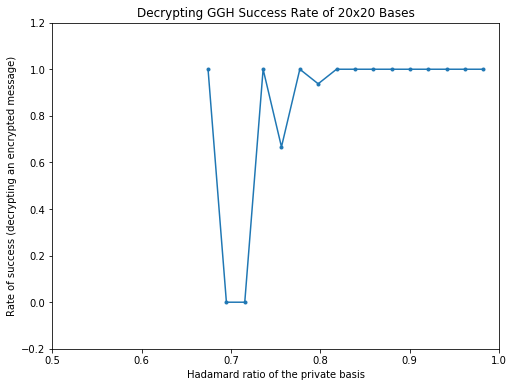

<Figure size 432x288 with 0 Axes>

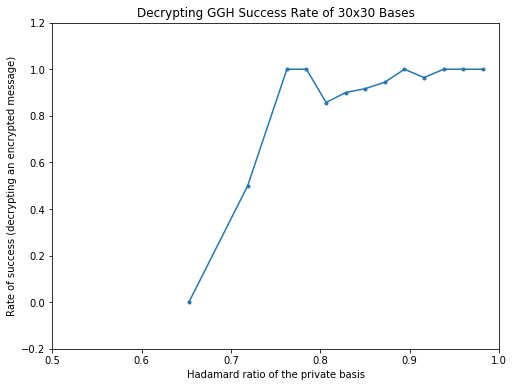

<Figure size 432x288 with 0 Axes>

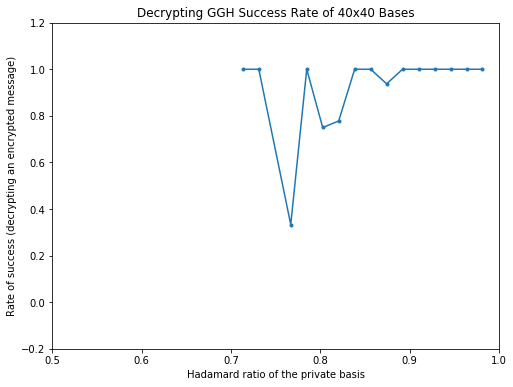

<Figure size 432x288 with 0 Axes>

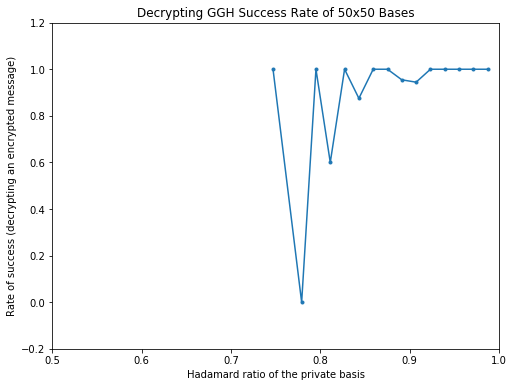

KeyboardInterrupt: 

In [60]:

def test_ggh_decryption():
    """
    Test how often GGH decryption fails for different Hadamard ratios of the
    private basis. How does this vary with n?
    """

    scale = 1000
    trials = 200

    data = []
    for n in [10, 20, 30, 40, 50, 60]:

        points = []
        for i in range(trials):
            private = random_hadamard_bounded_matrix(n, scale=scale, min_bound=0.5, max_bound=0.8)
            public = gen_bad_basis(private, ratio=0.05)
            ratio = hadamard_ratio(private)

            msg = random_matrix(ZZ, 1, n, x=-scale, y=scale)
            encrypted_message = ggh_encrypt(public, msg, delta=10)
            rec = ggh_decrypt(private, public, encrypted_message)

            if rec == msg:
                points.append((ratio, 1))
            else:
                points.append((ratio, 0))

        points.sort(key=lambda x: x[0])
        ratios, success = bin_by_ratios(points, 16)
        data.append((n, ratios, success))

        plt.clf()
        fig = plt.figure(figsize=(8, 6))
        plt.title('Decrypting GGH Success Rate of {0}x{0} Bases'.format(n))
        plt.xlabel('Hadamard ratio of the private basis')
        plt.ylabel('Rate of success (decrypting an encrypted message)')
        plt.xlim(0.5, 1.0)
        plt.ylim(-0.2, 1.2)
        plt.plot(ratios, success, '.-')
        fig.savefig('./img/decryption_success_{}.png'.format(n), dpi=100)
        plt.show()

    return data

_ = test_ggh_decryption()

In [ ]:

def test_ggh_cracking():
    """
    Test how often GGH cracking fails for different Hadamard ratios of the
    public basis. How does this vary with n?
    """

    scale = 1000
    trials = 100

    data = []
    for n in [60, 65, 70]:

        points = []
        for i in range(trials):
            private = random_hadamard_bounded_matrix(n, scale=scale, min_bound=0.9, max_bound=1.0)
            public = gen_bad_basis(private, ratio=0.1)
            ratio = hadamard_ratio(public)

            msg = random_matrix(ZZ, 1, n, x=-scale, y=scale)
            encrypted_message = ggh_encrypt(public, msg, delta=10)
            rec = ggh_crack(public, encrypted_message)

            if rec == msg:
                points.append((ratio, 1))
            else:
                points.append((ratio, 0))

        points.sort(key=lambda x: x[0])
        ratios, success = bin_by_ratios(points, 16)
        data.append((n, ratios, success))

        plt.clf()
        fig = plt.figure(figsize=(8, 6))
        plt.title('Cracking GGH Success Rate of {0}x{0} Bases'.format(n))
        plt.xlabel('Hadamard ratio of the public basis')
        plt.ylabel('Rate of success (cracking an encrypted message)')
        plt.ylim(-0.2, 1.2)
        plt.plot(ratios, success, '.-')
        fig.savefig('./img/cracking_success_{}.png'.format(n), dpi=100)
        plt.show()

        raw_ratios = [x[0] for x in points]
        plt.clf()
        plt.hist(raw_ratios)
        plt.show()

    return data

_ = test_ggh_cracking()

In [ ]:

def test_cracking_LLL_scale():
    """
    Test how often GGH cracking fails for different Hadamard ratios of the
    public basis. How does this vary with n?
    """

    scale = 100
    trials = 10

    n = 50
    times_for_scale = {}
    data = []
    for scale in [10 ** 10, 10 ** 20, 10 ** 30, 10 ** 40]:

        points = []
        for i in range(trials):
            current = time.time()
            private = gen_good_basis(n, scale, ratio=0.5)
            #print("gen_good_basis:", time.time()-current)
            current = time.time()
            public = gen_bad_basis(private, ratio=0.1)
            #print("gen_bad_basis:", time.time()-current)
            ratio = hadamard_ratio(public)

            msg = random_matrix(ZZ, 1, n, x=-scale, y=scale)
            current=time.time()
            encrypted_message = ggh_encrypt(public, msg, delta=10)
            #print("ggh_encrypt:", time.time()-current)
            current = time.time()
            rec = ggh_crack(public, encrypted_message)
            if scale in times_for_scale:
                times_for_scale[scale] += (time.time()-current)
            else:
                times_for_scale[scale] = (time.time()-current)

            #times_for_scale.append(' '.join(["Time for scale", str(scale), ":",str(time.time()-current)]))

            if rec == msg:
                points.append((ratio, 1))
            else:
                points.append((ratio, 0))

        points.sort(key=lambda x: x[0])
        ratios, success = bin_by_ratios(points, 16)
        #ratios = [x[0] for x in points]
        #success = [x[1] for x in points]
        data.append((n, ratios, success))

        #for n, ratios, success in data:
        plt.clf()
        plt.title('Cracking GGH Success Rate (n={})'.format(n))
        plt.xlabel('Hadamard ratio of the public basis')
        plt.ylabel('Rate of success (cracking an encrypted message)')
        #plt.xlim(0.5, 1.0)
        plt.ylim(-0.2, 1.2)
        plt.plot(ratios, success, '.-')
        #plt.show()

        raw_ratios = [x[0] for x in points]
        plt.clf()
        plt.hist(raw_ratios)
        #plt.show()
    
    for x in sorted(times_for_scale.keys()):
        print "For scale:",x,"average time", times_for_scale[x]/trials
    
    return data

test_cracking_LLL_scale()